CNN LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,Flatten,TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

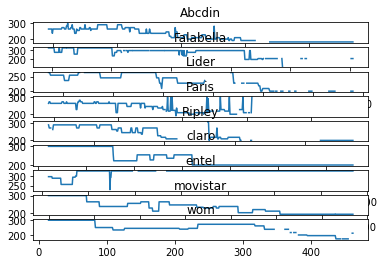

In [2]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
#print(df_wide)
#print(df_wide.columns)
i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

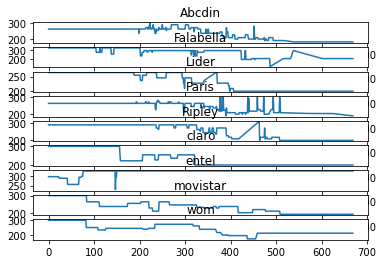

In [4]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure()
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [5]:
company = "Abcdin"
raw_seq = df_wide[company]
n_steps = 16
X, y = split_sequence(raw_seq, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
#print(len(X))
X_train = X[:value]
#print(len(X_train))
y_train = y[:value]
X_test = X[value:]
#print(len(X_test))
y_test = y[value:]

CNN LSTM

In [6]:
n_features = 1
n_seq = 2
n_steps = n_steps//2
X_train = X_train.reshape((X_train.shape[0],n_seq,n_steps,n_features))
X_test = X_test.reshape((X_test.shape[0],n_seq,n_steps,n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Epoch 1/50
7/7 [==============================] - 2s 45ms/step - loss: 36806.0742 - val_loss: 4513.1157
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 2948.0952 - val_loss: 1266.8550
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 3045.3855 - val_loss: 202.1436
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 231.3032 - val_loss: 168.9304
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 226.3827 - val_loss: 16.6961
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 136.3012 - val_loss: 15.3343
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 133.6594 - val_loss: 13.8788
Epoch 8/50
7/7 [==============================] - 0s 6ms/step - loss: 123.1291 - val_loss: 18.4126
Epoch 9/50
7/7 [==============================] - 0s 6ms/step - loss: 125.9251 - val_loss: 18.0366
Epoch 10/50
7/7 [==============================] - 0s 6ms/step - loss: 125.1803 - val_loss: 15.390

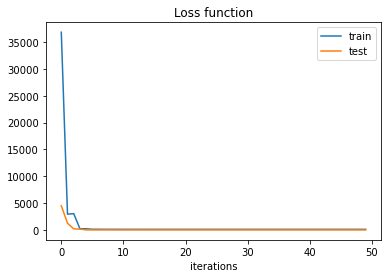

In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False)
#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.show()

7/7 [==============================] - 0s 1ms/step
Test MSE: 15.976


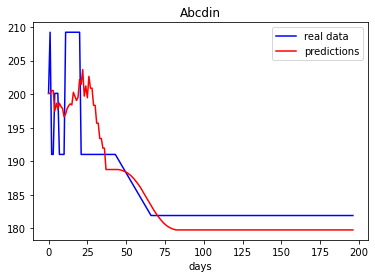

In [8]:
yhat = model.predict(X_test)

mse = mean_squared_error(y_test, yhat)
print('Test MSE: %.3f' % mse)

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.title(company)
plt.xlabel("days")
plt.legend()
plt.show()
